<a href="https://colab.research.google.com/github/0xd1rac/cv-papers/blob/main/r_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.youtube.com/watch?v=5DvljLV4S1E&t=377s

This is an implementation of the paper, "Rich feature hierarchies for accurate object detection and semantic segmentation" by Ross Girshick, Jeff Donahue, Trevor Darrell and Jitendra Malik from UC Berkeley. The paper was published on 22 Oct 2014. \

In this paper the authors attempt to brdige the gap between image classification and object detection. This paper is the first to show that a CNN can lead to dramatrically higer object detection performance on PASCAL VOC.

The approach in the paper combines two key insights:
 1. One can apply high-capacity convolutional neural net- works (CNNs) to bottom-up region proposals in order to localize and segment objects.
 2. When labeled training data is scarce, supervised pre-training for an auxiliary task, followed by domain-specific fine-tuning, yields a significant performance boost.


Since the paper combines region proposals with CNNs, the authors call the method R-CNN: Regions with CNN features.

Link to paper:

Image detection - requires localizing many objects within an image

**Approaches**
1. Frames localization as a regression problems - does not fare well in practise - unsure why tho

2. Sliding-window detector

  This is very common and CNNs have be used in this way for at least 2 decades.

  The challenge is that when using a deep CNN (with many layers), the large receptive fields and large strides make it difficult to accurately detect and localize objects within the sliding-window approach.
  
  The network may struggle to precisely determine the boundaries of objects, especially smaller ones, because of the coarse spatial resolution at the higher layers of the CNN.

3. Recognition using regions (used in this paper).
  
  R-CNN generates around 2000 category-independant region proposals for the input image > use affine image warmping to compute a fixed size input for the CNN > extracts a fixed-length feature vector from each proposal using a CNN > classify each reigion with category specific CNN >

  Basically, instead of doing sliding window, we use an algorithm that generates region that could possibly contain objects in it.







# R-CNN

R-CNN objection detection system consists of three modules.
1. Generates category-independent region proposls thorugh selective search algorithm.
2. Large CNN that extracts a fix-length feature vector from each region (original paper uses alexnet).
3. Class specific linear SVMs

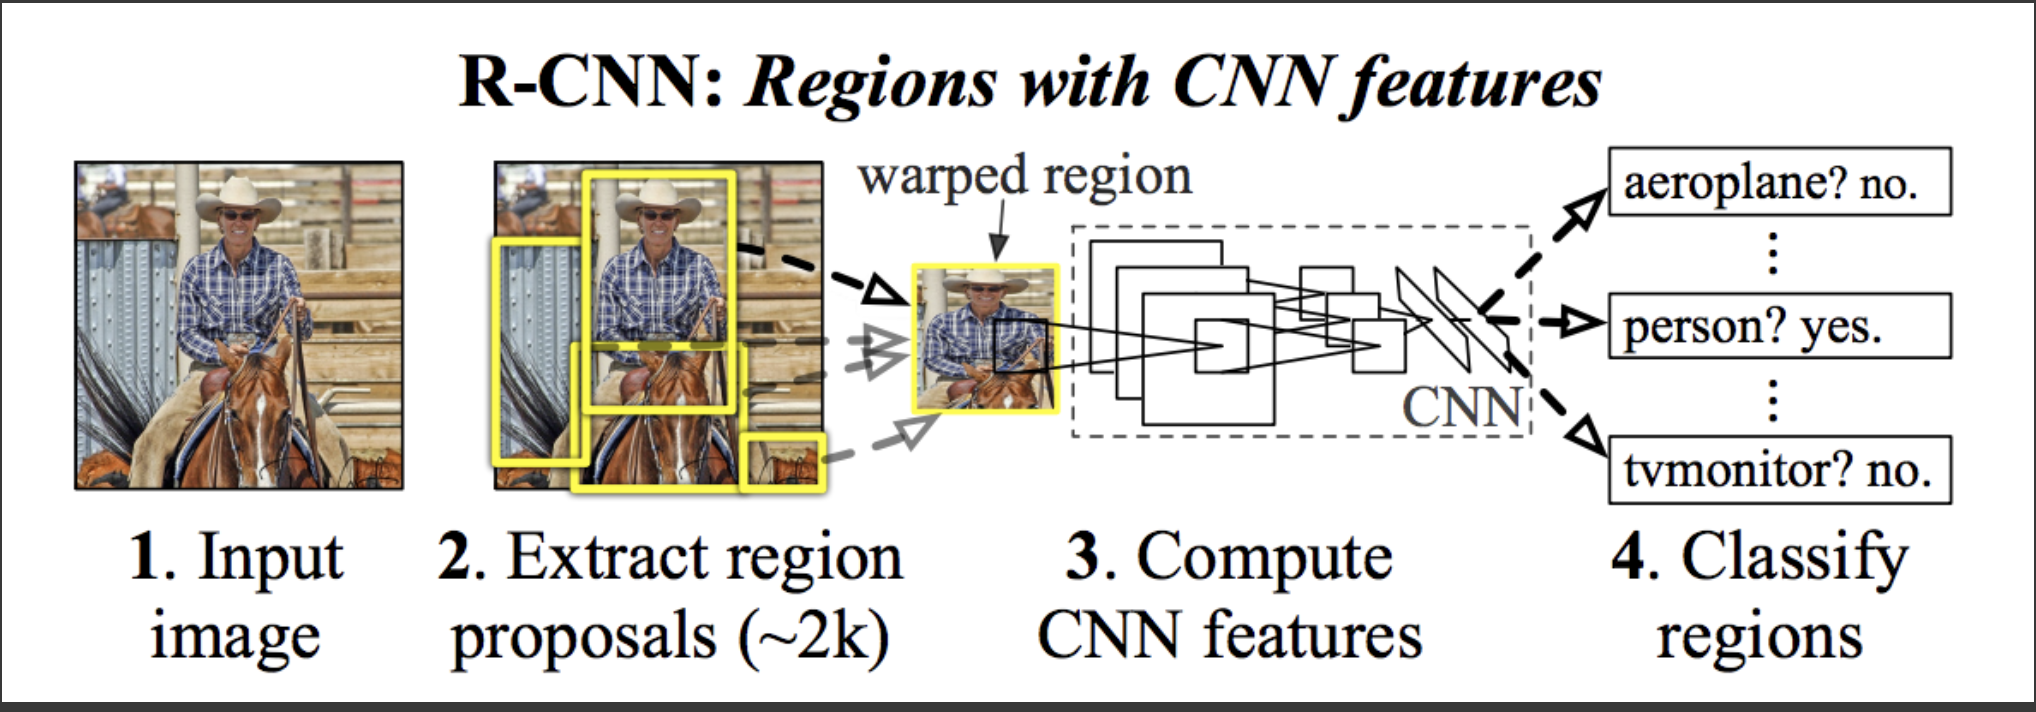

# Module 1: Selective search

Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

## Region Proposal Generation

In [ ]:
import cv2
import matplotlib.pyplot as plt

def selective_search(image_path, strategy='fast', display=False):
    """
    Perform selective search on an image and return the region proposals.

    Parameters:
    - image_path: str, path to the input image.
    - strategy: str, 'fast' for faster and less accurate, 'quality' for more accurate but slower.
    - display: bool, if True, display the image with region proposals.

    Returns:
    - rects: list of tuples, each tuple contains (x, y, width, height) of a region proposal.
    """

    # Load an image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Initialize Selective Search segmentation object
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

    # Set the base image on which selective search will be run
    ss.setBaseImage(image)

    # Choose strategy
    if strategy == 'fast':
        ss.switchToSelectiveSearchFast()
    elif strategy == 'quality':
        ss.switchToSelectiveSearchQuality()
    else:
        raise ValueError("Strategy must be 'fast' or 'quality'")

    # Run selective search
    rects = ss.process()

    if display:
        # Convert image from BGR to RGB for matplotlib display
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Draw the region proposals on the image
        for (x, y, w, h) in rects:
            cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Show the image with the region proposals
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.axis('off')  # Hide axis
        plt.show()

    return rects

In [ ]:
import random
def display_random_bounding_box(image_path, rects):
    """
    Display the image with one randomly sampled bounding box.

    Parameters:
    - image_path: str, path to the input image.
    - rects: list of tuples, each tuple contains (x, y, width, height) of a region proposal.
    """
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")

    # Convert image from BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Randomly select one bounding box
    random_bbox = random.choice(rects)
    x, y, w, h = random_bbox

    # Draw the bounding box on the image
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the image with the bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')  # Hide axis
    plt.show()

In [ ]:
img_path = "/content/drive/MyDrive/Deep Learning Papers/papers/obj_detect.jpg"
rects = selective_search(img_path, 'fast', True)
print(f"{rects.shape[0]} bounding boxes were generated.")

ValueError: Image not found at path: /content/drive/MyDrive/Deep Learning Papers/papers/obj_detect.jpg

In [ ]:
display_random_bounding_box(img_path, rects)

## Calculating Intersection over Union (IoU)

- Bounding boxes with an IoU greater than 0.7 (0.5 in original paper) area considered as a postive example.
- Bounding boxes with an IoU less than 0.3 are taken to be negative examples.
- We will then take 30 postive and 30 negative examples (original paper have 32 and 96 respectively) of size 224x224
- Original also warps the examples but since we have resized them already, there is no need of it.

In [ ]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    - bb1: tuple or list with 4 elements (x_min, y_min, width, height) for the first bounding box.
    - bb2: tuple or list with 4 elements (x_min, y_min, width, height) for the second bounding box.

    Returns:
    - iou: float, the IoU between the two bounding boxes.
    """
    # Unpack the bounding boxes
    x1_min, y1_min, w1, h1 = bb1
    x2_min, y2_min, w2, h2 = bb2

    # Calculate the (x, y)-coordinates of the intersection rectangle
    x1_max = x1_min + w1
    y1_max = y1_min + h1
    x2_max = x2_min + w2
    y2_max = y2_min + h2

    xi_min = max(x1_min, x2_min)
    yi_min = max(y1_min, y2_min)
    xi_max = min(x1_max, x2_max)
    yi_max = min(y1_max, y2_max)

    # Compute the area of intersection rectangle
    inter_width = max(0, xi_max - xi_min)
    inter_height = max(0, yi_max - yi_min)
    inter_area = inter_width * inter_height

    # Compute the area of both bounding boxes
    bb1_area = w1 * h1
    bb2_area = w2 * h2

    # Compute the IoU
    union_area = bb1_area + bb2_area - inter_area
    iou = inter_area / union_area if union_area != 0 else 0

    return iou

In [ ]:
get_iou(rects[10], rects[66])

# Module 2: Feature extraction via AlexNet passing region proposals as input

**Input:** region proposal of dim (x,y)

**Input to CNN:** Affine warping to (227 x 227)

**Ouput:** 4096 feature vector

# Module 3: Class-specific linear SVMs

1. For each class, we score each extracted feature vector using the SVM trained for that class.
2. Given all scored regions in an image, we apply a greedy non-maximum suppression (for each class indepen- dently) that rejects a region if it has an intersection-over- union (IoU) overlap with a higher scoring selected region larger than a learned threshold.

  I HAVE NO IDEA WTF NON-MAX SUPRESSIONG IS!!

# Training

Training R-CNN involves 2 steps
1. Supervised pre-training on the object classification task on ImageNet Dataset
2. Domain-specific fine-tuning on the object detection task
  - Replace 1000-way classification layers with a randomly initialized (N+1)-way classification layer where N is the number of object classes, plus 1 for background.
  - CNN arch is unchanged
  - Treat all region proposal with >= 0.5 IoU overlap with a ground-truth box as positives for that box's class and teh rest as negatives.
  - After scoring each selec- tive search proposal with a class-specific detection SVM, we predict a new bounding box for the detection using a class-specific bounding-box regressor.

## 0. Dataset

In [ ]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.7/942.7 kB 44.5 MB/s eta 0:00:00

In [ ]:
import torch
import fiftyone as fo
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class CocoDataset(Dataset):
    def __init__(self, fiftyone_dataset, label_map, transform=None):
        self.dataset = fiftyone_dataset
        self.label_map = label_map
        self.transform = transform
        self.filepaths = self.dataset.values("filepath")

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        filepath = self.filepaths[idx]
        sample = self.dataset.match({"filepath": filepath}).first()
        image = Image.open(filepath)

        # Get the bounding boxes and labels
        boxes = []
        labels = []
        for detection in sample.ground_truth.detections:
            x, y, w, h = detection.bounding_box
            # Convert bounding box to absolute coordinates
            x_min = x * image.width
            y_min = y * image.height
            x_max = (x + w) * image.width
            y_max = (y + h) * image.height
            boxes.append([x_min, y_min, x_max, y_max])

            # Convert the label from string to integer
            label = self.label_map[detection.label]
            labels.append(label)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels}
        return image, target

In [ ]:
train_dataset = fiftyone.zoo.load_zoo_dataset("coco-2017", split="train", max_samples=300)


# You can also automatically create this map by collecting all unique labels from the dataset
unique_labels = train_dataset.distinct("ground_truth.detections.label")
label_map = {label: idx + 1 for idx, label in enumerate(unique_labels)}

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
import fiftyone

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CocoDataset(fiftyone.zoo.load_zoo_dataset("coco-2017", split="train", max_samples=300),
                            transform=transform
                            )

val_dataset = CocoDataset(fiftyone.zoo.load_zoo_dataset("coco-2017", split="validate", max_samples=50),
                           transform=transform
                          )

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train-300'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading existing dataset 'coco-2017-train-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'coco-2017-train-50'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


In [ ]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
test_dl = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
for images, targets in train_dl:
  print(images)  # Tensor of images
  print(targets)
  break


/usr/local/lib/python3.10/dist-packages/pymongo/mongo_client.py:2353: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  return self._read() if self._is_read else self._write()
/usr/local/lib/python3.10/dist-packages/pymongo/mongo_client.py:2353: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  return self._read() if self._is_read else self._write()
/usr/local/lib/python3.10/dist-packages/pymongo/mongo_client.py:2353: UserWarning: MongoClient opened before fork. May not be entirely fork-safe, proceed with caution. See PyMongo's documentation for details: https://pymongo.readthedocs.io/en/stable/faq.html#is-pymongo-fork-safe
  return self._read() if self._is_read else 

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-63-f3b9e89c04d5>", line 36, in __getitem__
    labels = torch.tensor(labels, dtype=torch.int64)  # Assuming labels are integer-encoded
ValueError: too many dimensions 'str'


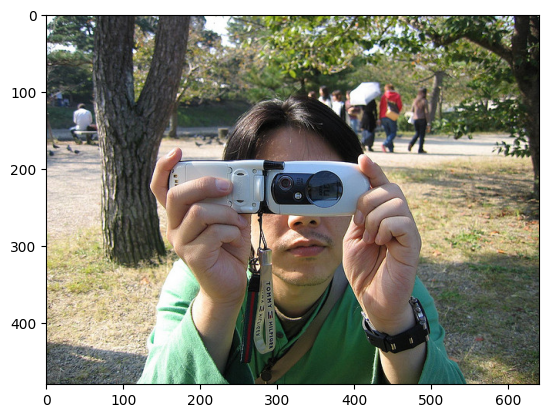

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

filepath = '/root/fiftyone/coco-2017/validation/data/000000120420.jpg'

image = Image.open(filepath)
# Create a plot to display the image
fig, ax = plt.subplots(1)
ax.imshow(image)



In [ ]:
file_path_lis = []
label_lis = []
bounding_box_lis = []
for sample in dataset:
  file_path_lis.append(sample['filepath'])
  # img_width = sample['metadata']['width']
  # img_height = sample['metadata']['height']
  for d in sample['ground_truth']['detections']:
    label_lis.append(d['label'])
    bounding_box_lis.append(d['bounding_box'])
    print(d['bounding_box'])

  break

[0.23932812499999997, 0.3934166666666667, 0.42471875, 0.15504166666666666]
[0.17953125, 0.22616666666666668, 0.6728125, 0.7738333333333334]
[0.732, 0.19164583333333332, 0.04625, 0.18602083333333336]
[0.673046875, 0.18364583333333334, 0.049890625, 0.19954166666666667]
[0.62671875, 0.24429166666666668, 0.044515624999999996, 0.13241666666666668]
[0.056578125, 0.31316666666666665, 0.049734375, 0.035812500000000004]
[0.578125, 0.20429166666666668, 0.031671875, 0.07793749999999999]
[0.554796875, 0.19320833333333332, 0.026875, 0.06004166666666667]
[0.020749999999999998, 0.20629166666666665, 0.011578125, 0.042749999999999996]
[0.53078125, 0.20895833333333333, 0.02153125, 0.0228125]
[0.042140625, 0.3515, 0.013328125, 0.022791666666666665]
[0.0133125, 0.35085416666666663, 0.015890625, 0.015541666666666667]
[0.61440625, 0.1818125, 0.06493750000000001, 0.06891666666666667]
[0.04796875, 0.239375, 0.0503125, 0.11264583333333333]
[0.606640625, 0.204625, 0.031671875, 0.12297916666666667]
[0.32309375, 

## 1. Pre-training on the Classification task on Imagenet Dataset

AlexNet architecture trained on the Imagenet Dataset in the paper. However I have used VGGNet-16 pretrained instead here

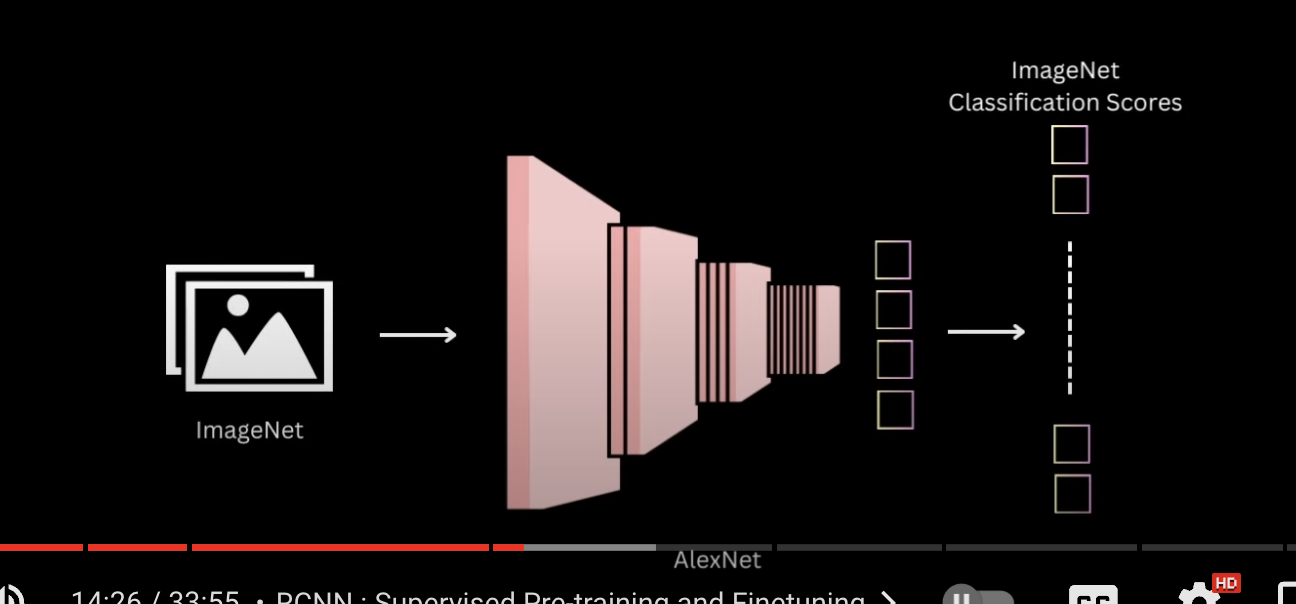

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
model = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:14<00:00, 37.1MB/s]


## 2. Domain Specific Fine-Tuning on Classifcation Task on Labelled Image Proposals

### 2.1 Change the classiifcation layer


Change the last classification layer to (N + 1) where N is the number of classes in the objection detection task and 1 is the background.

If the dataset contains images of a person and a car, the classifcation alyer will be (2 + 1) = 3

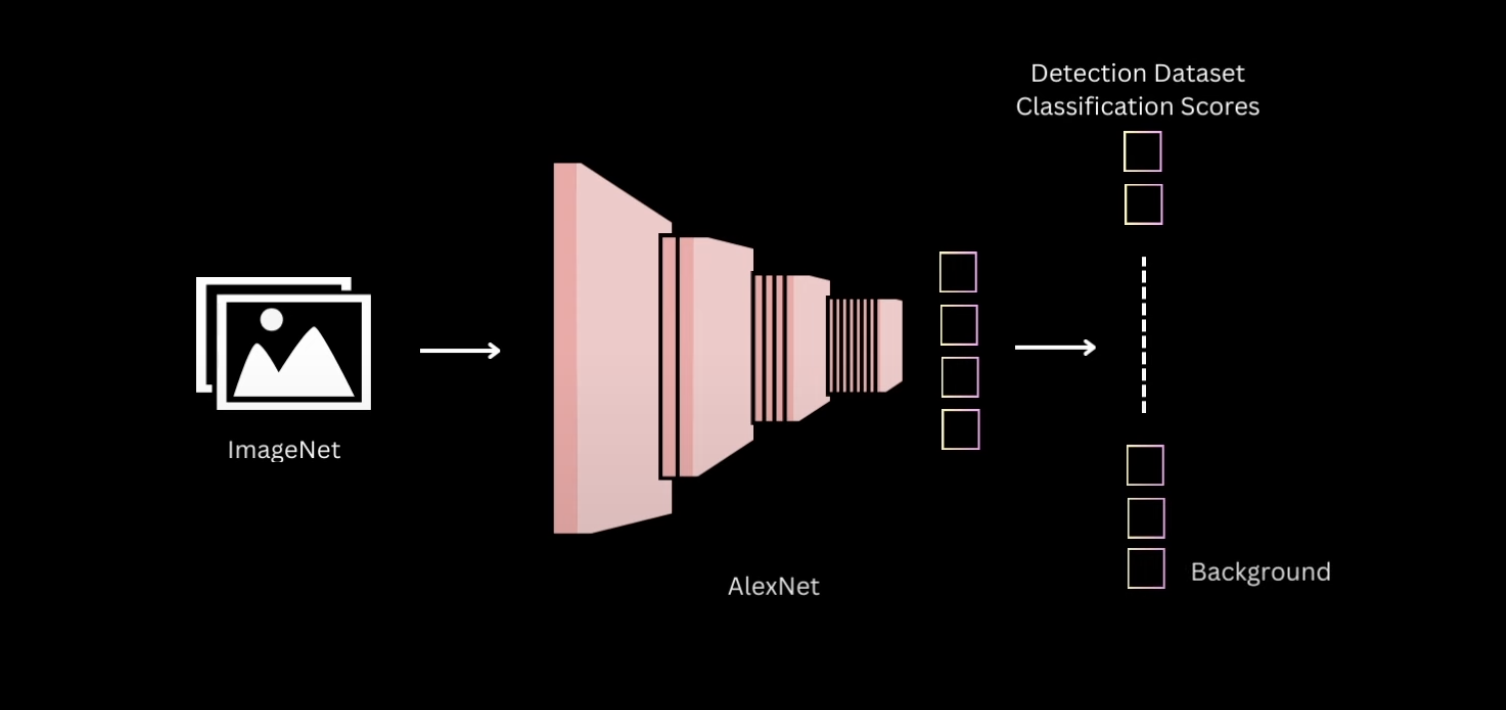

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [ ]:
num_classes_coco = 80
model.classifier[6] = nn.Linear(in_features=4096,
                                out_features = num_classes_coco + 1,
                                bias=True
                                )

In [ ]:
print(model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=6, bias=True)
)


### 2.2 Image Warping

The ImagetNet arch expect the input image to be of dimension, 227 x 227. But our region proposals are off different dimensions. We will need to warp the images to make it 227 x 227 before passing into the CNN.

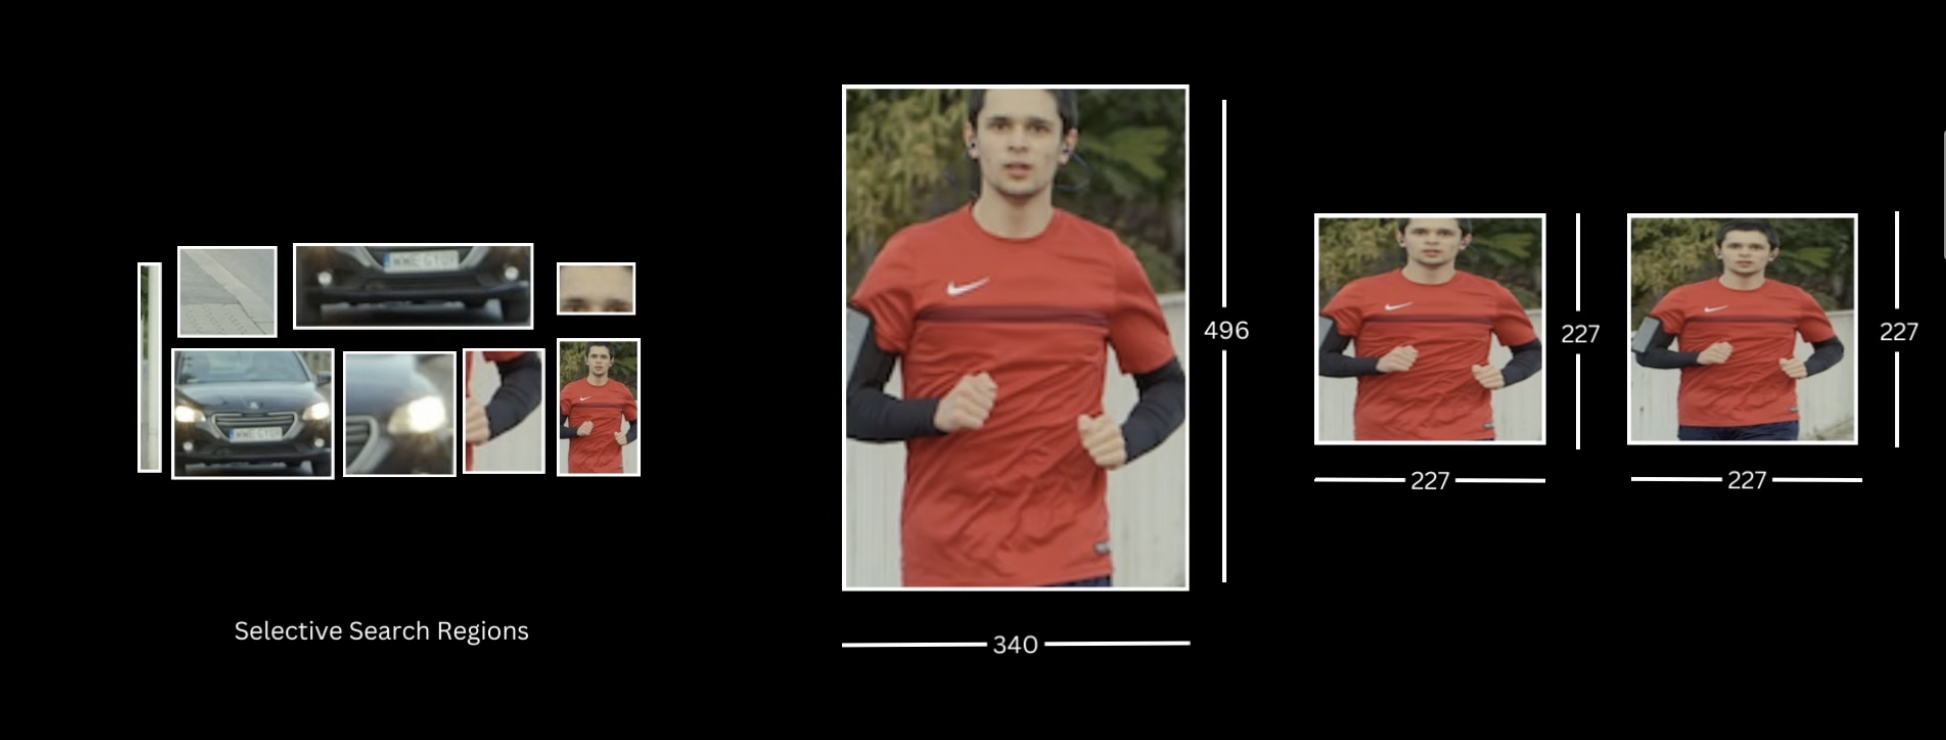

### 2.3 Labelling the region proposals

In our dataset, we have images where we know the ground truth box coordinates.


Assuming that we have two ground truth boxes:

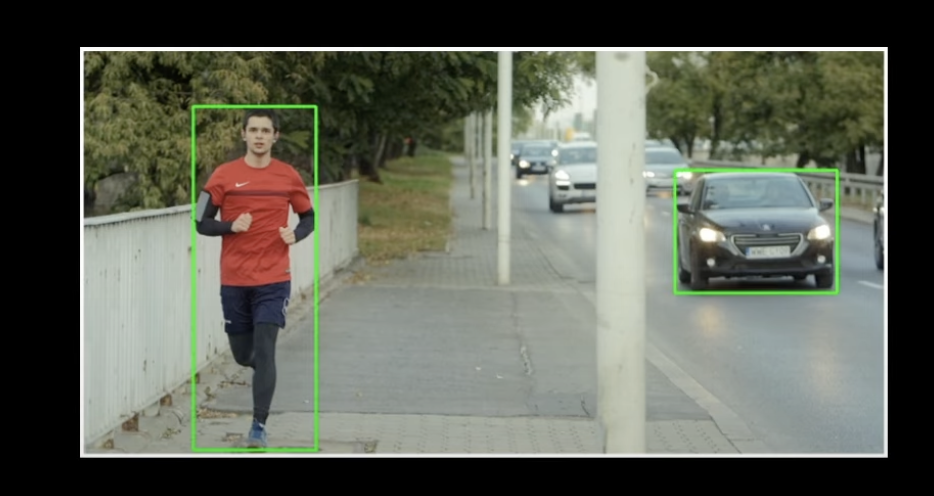

These are the 1600 region proposals that selective search returns:

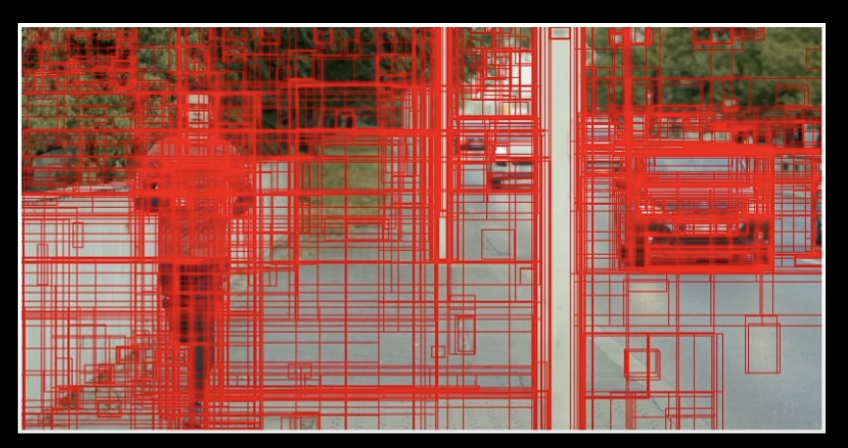

proposals with label as class K: region proposals that have the IOU >= 0.5 with GT boxes of that class

proposals with labels as class Backgorund: all remaining proposals



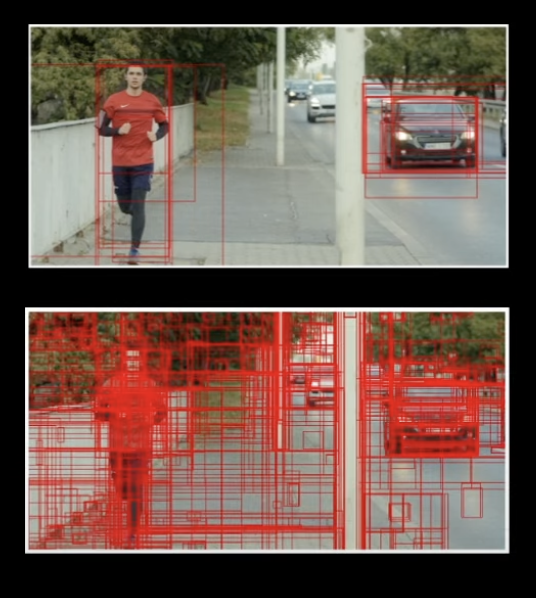

In [ ]:
def label_region_proposals(gt_rects, proposal_rects):
  class_k_proposals = []
  background_proposals = []

  for proposal in proposal_rects:
    max_iou = 0
    for


SyntaxError: invalid syntax (<ipython-input-9-c74adf0863f5>, line 7)

**Qn:**

What if the region proposal overlaps with two ground truth boxes?

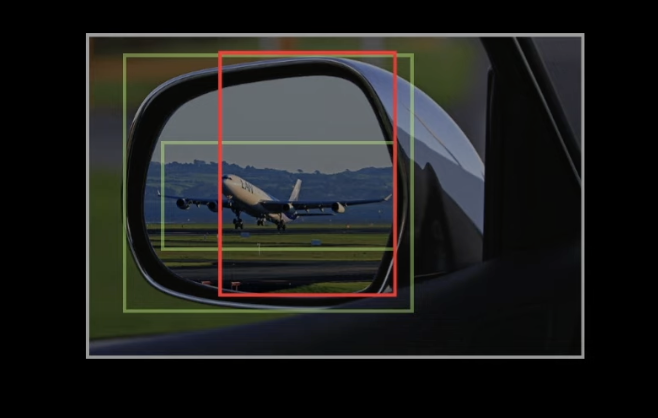

**Answer:**
Associate each region prosal to the ground-truth instance with which it has maximum IoU overlap

get_iou(bb1, plane_box): 0.8
get_iou(bb1, car_window_box): 0.6,

we choose to label bb1 as 'plane'


###  2.4 Classification Pre-training using labelled region proposals


Now that we have a dataset containining positive and negative classes.

To finetune the network, we will

1. Sample from both positive and negative classes to create a batch.
2. Negative classes will have the label, background class and the positive classes will have the label, "car" or "person".
3. Finetune using cross entropy loss.


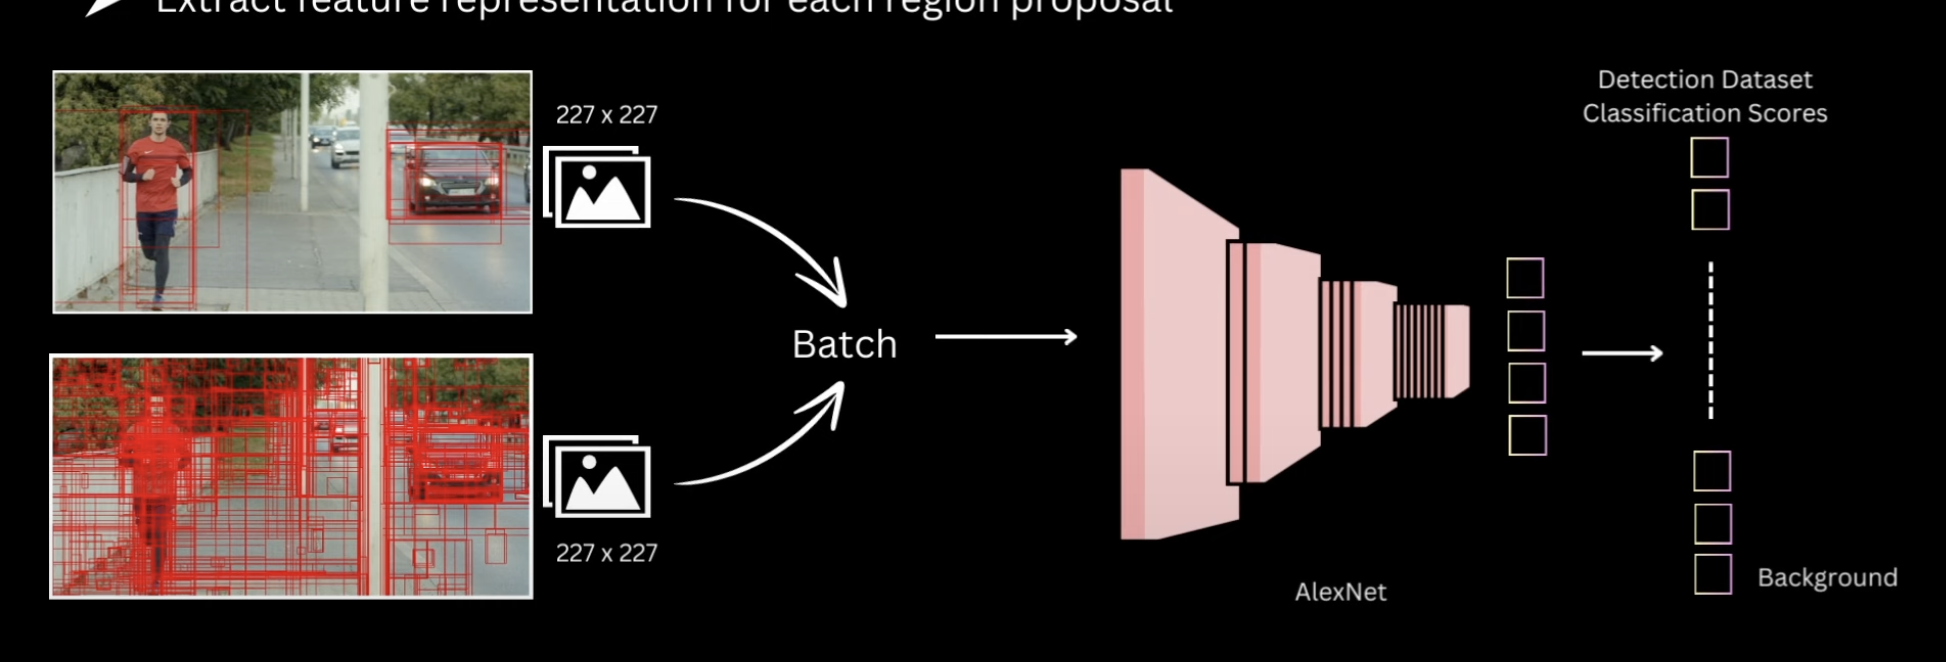

## 3. Domain Specific Fine Tuning: SVM Training - I dont rlly get this shit tbh

If there are 5 classes, 5 SVMs will be trained. If the image contains 3 classes, 3 of the SVMs will be True and 2 of them will be False. This allows you to detect the 3 objects that are in the input image

### 3.1 Remove the classification layer

Remove the classification layer and use the fully connected layer output as a the feature output

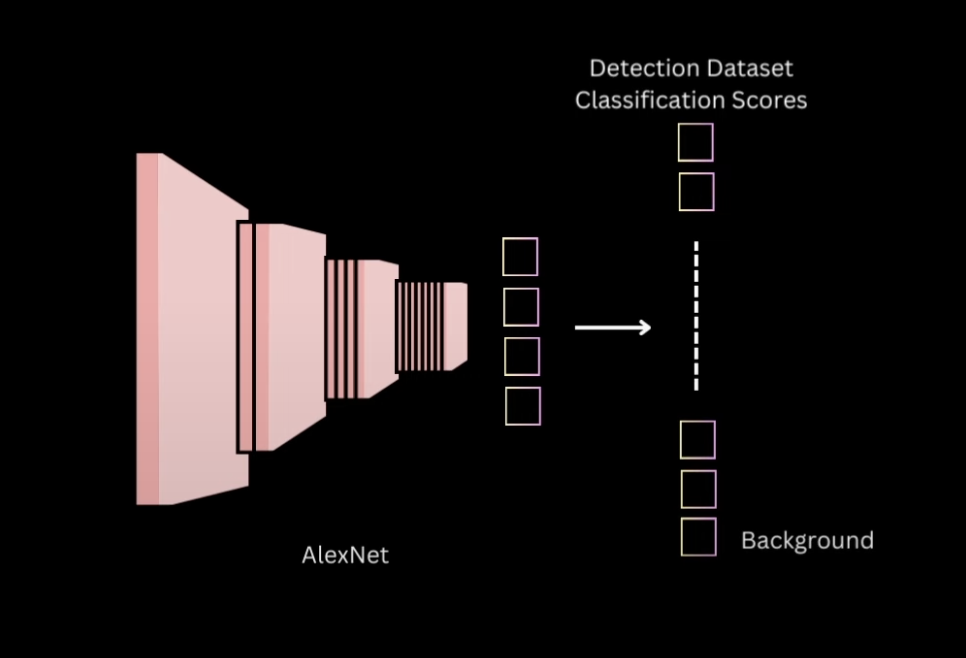

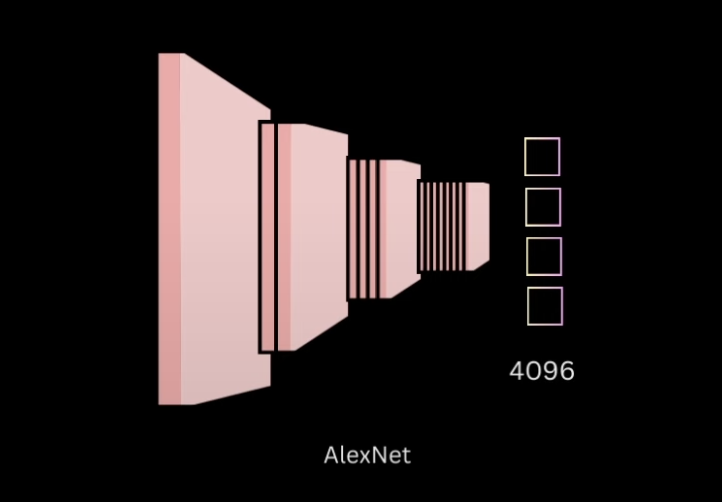

### 3.2 Generate Labels

Positive labelled proposals for class K: GT boxes for that class

Negative labelled proposals for class K: Proposals with <0.3 IoU with All GT boxes of Class K

### 3.2 Train a linear SVM for each class
To classify feature vector / representations as positive or negative

## 4. Train a class specific Bounding Box Regressor

### 4.1 How training and infernece works

We have coordinates for the region proposal box.

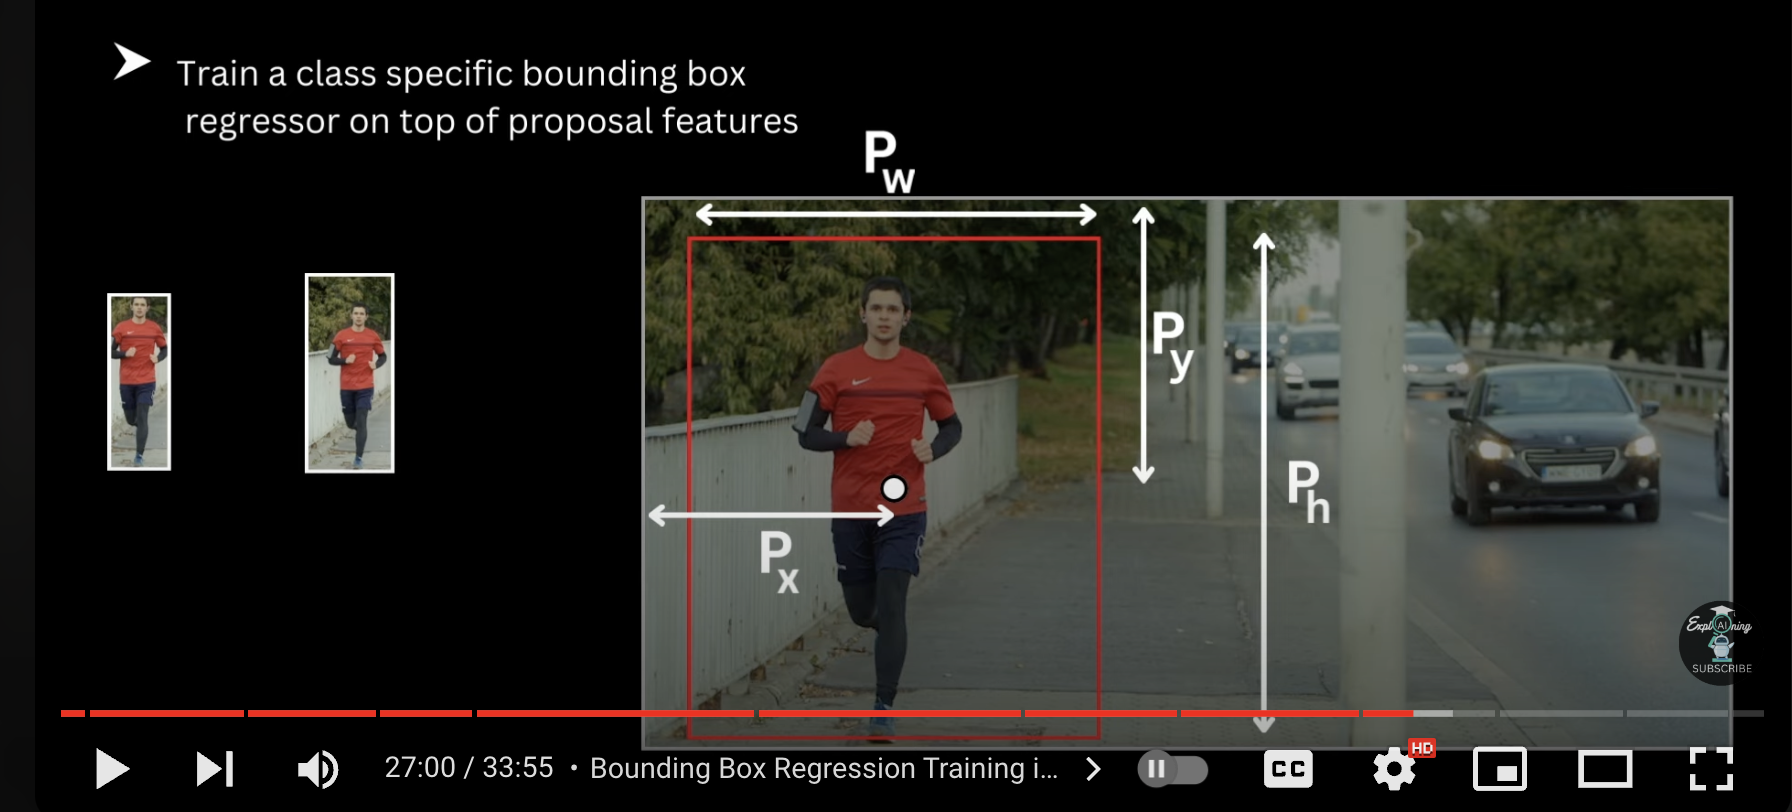

We have the coordinates for the ground truth box.

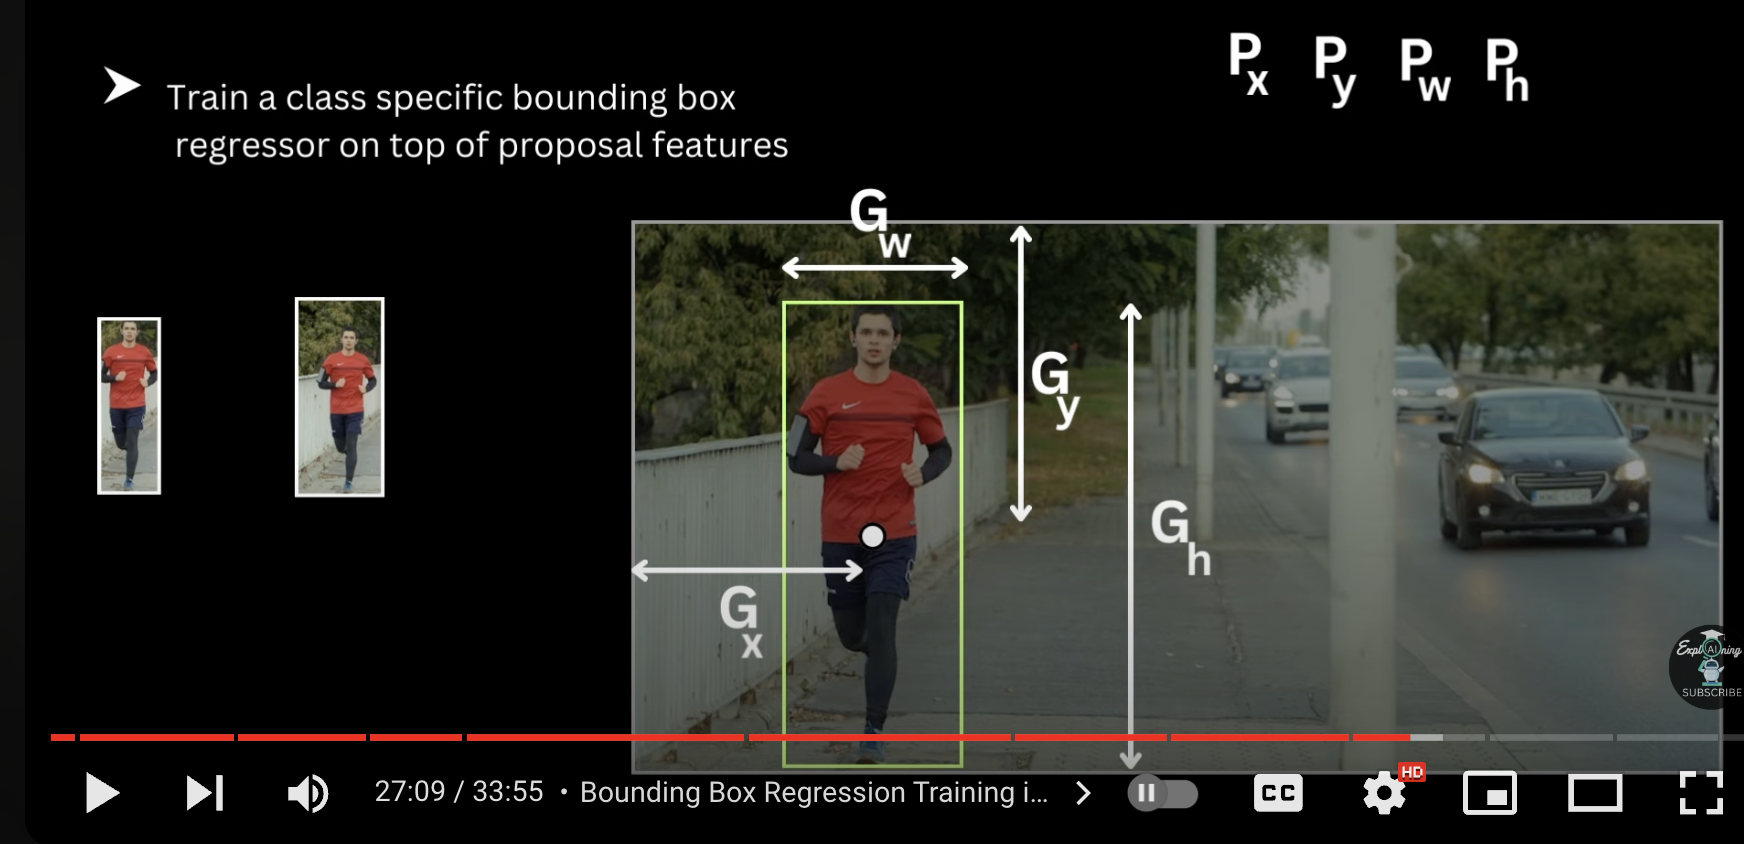

The authors pamarmeterized the region proposal box coordinates and rewrote it to into parameters a linear regression model can predict.

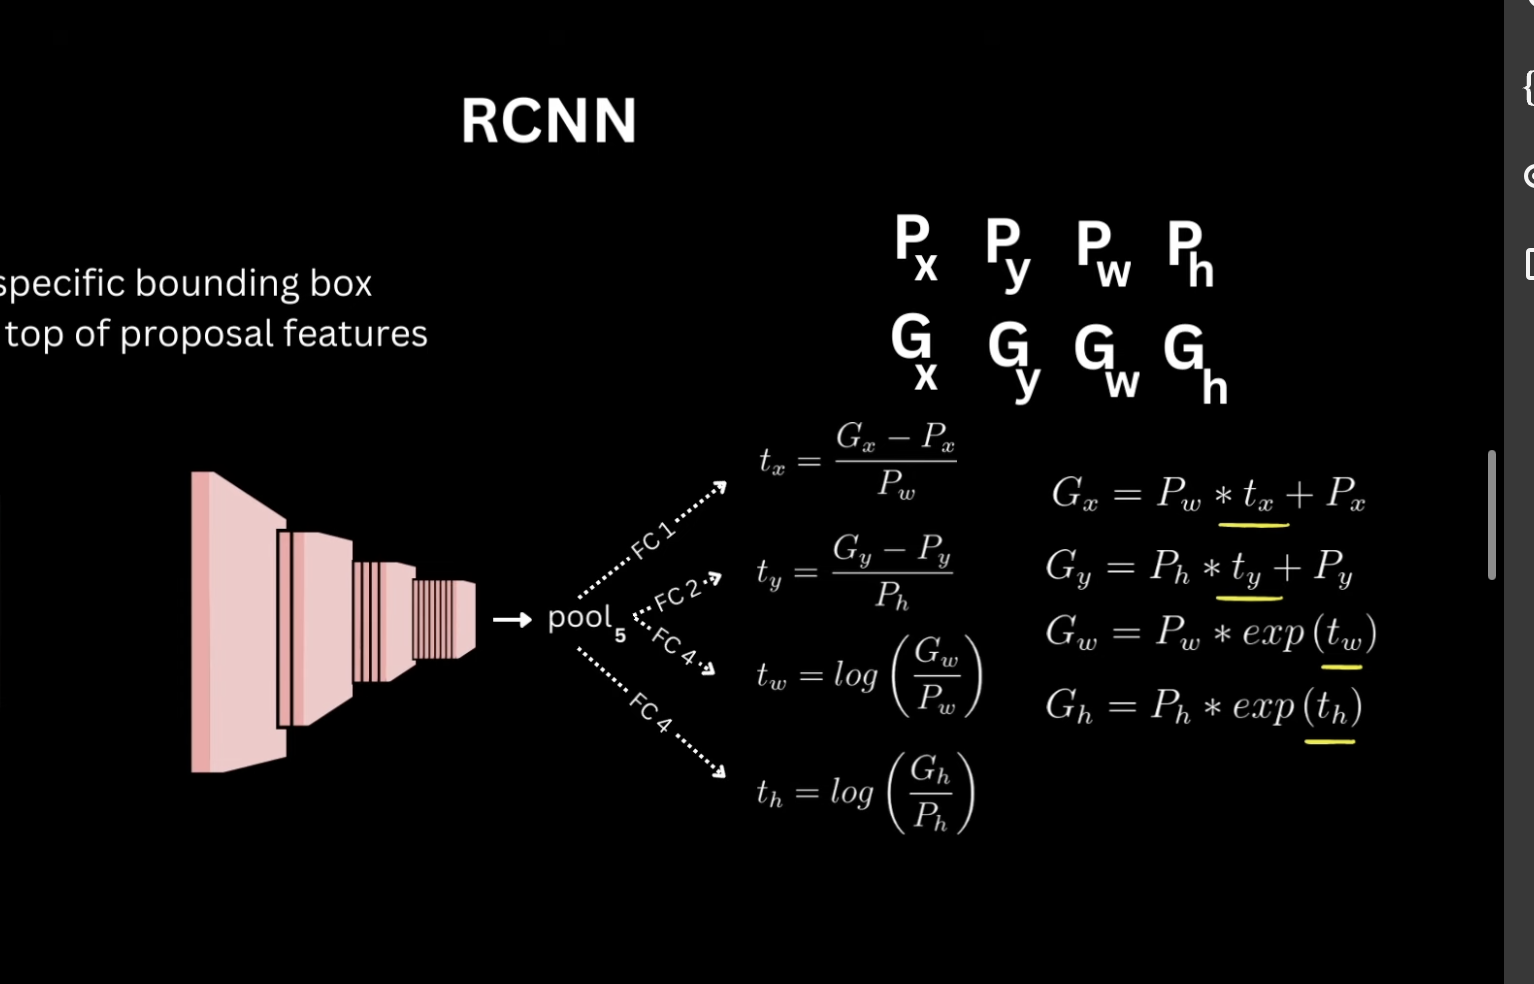

During inference, given a region proposal, we can calculate the transformation parameters.

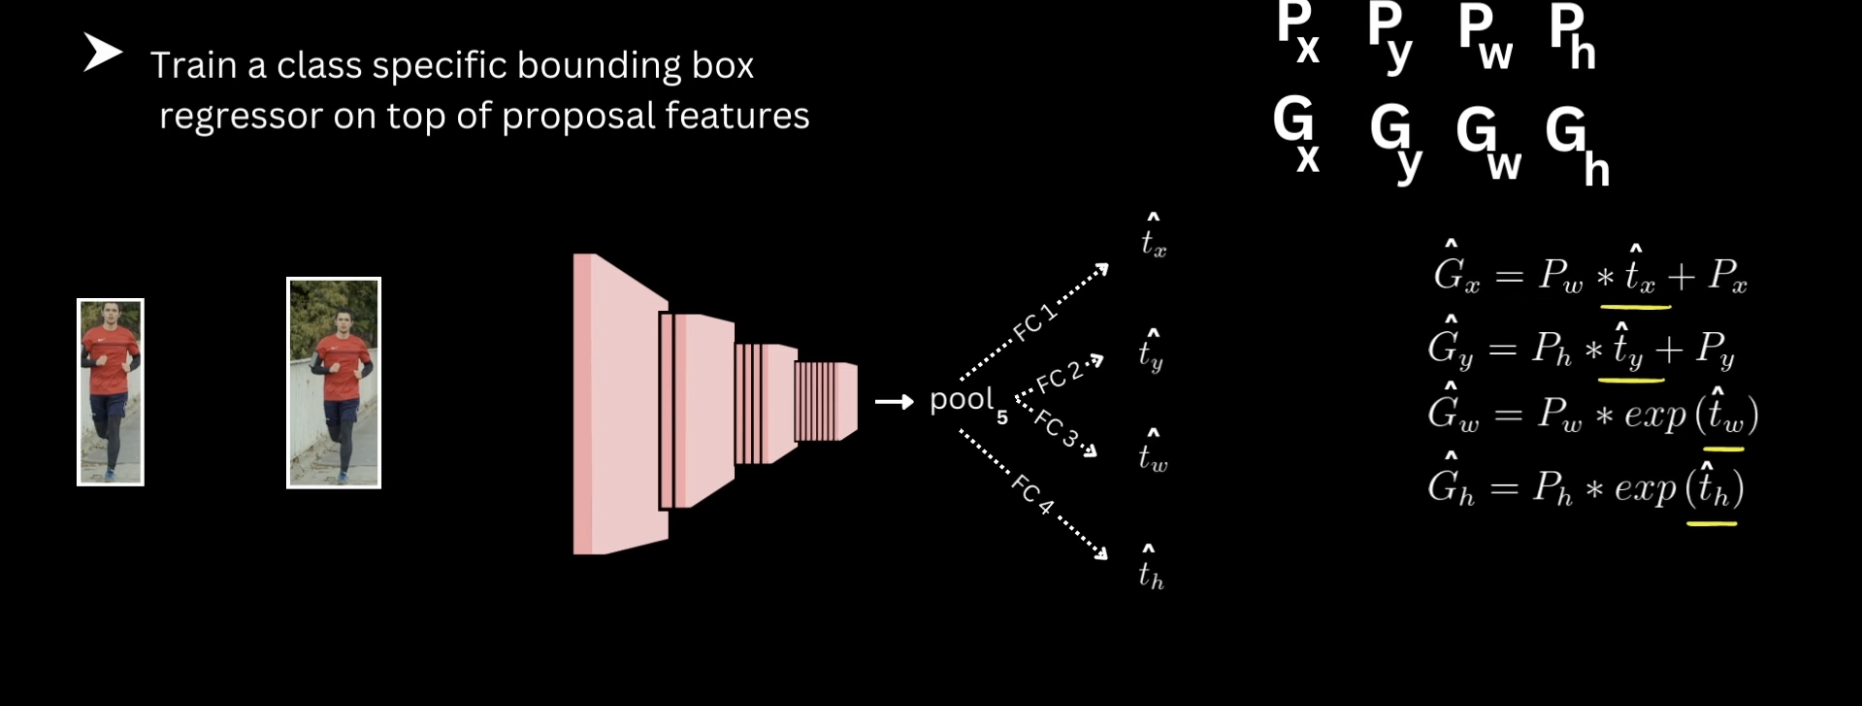

### 4.2 Labelling data

The authors assign each region propsal with one ground truth box which it has maximum overlap (IOU) if the IOB > 0.6. If a region proposal does not have a ground truth box with IoU > 0.6, it will not be used for training the regressor.

## 5. Filter prediction using NMS